### In this task we have 2 subtasks:
1. Classify human or ai text
2. Group texts into categories (crime, science, religion business)
---
[Task Link](https://judge.nitro-ai.org/roai-2025/onia/problems/1/task)

In [16]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

df_train = pd.read_csv("data/train_data.csv")
df_test = pd.read_csv("data/test_data.csv")

In [17]:
X = df_train["text"]
y = df_train["label"]
X_task1 = df_test[df_test["subtaskID"] == 1]
X_task2 = df_test[df_test["subtaskID"] == 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Task 1 (Binary Classification)

In [18]:
task1_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('model', LinearSVC())
])

task1_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('model', LinearSVC())])

In [19]:
y_pred = task1_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.956
Confusion Matrix:
 [[683  12]
 [ 32 273]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       695
         1.0       0.96      0.90      0.93       305

    accuracy                           0.96      1000
   macro avg       0.96      0.94      0.95      1000
weighted avg       0.96      0.96      0.96      1000



In [20]:
task1_pred = task1_pipeline.predict(X_task1["text"])

task1 = pd.DataFrame({
    "subtaskID": [1] * len(task1_pred),
    "datapointID": X_task1["ID"].values,
    "answer": task1_pred
})

## Task 2 (Clustering)

In [21]:
task2_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('model', KMeans(n_clusters=4, random_state=42, n_init=500))
])

task2_pipeline.fit(X_task2["text"])

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('model', KMeans(n_clusters=4, n_init=500, random_state=42))])

In [22]:
clusters = task2_pipeline.predict(X_task2["text"])

label_map = {0: "SCIENCE", 1: "CRIME", 2: "BUSINESS", 3: "RELIGION"}
mapped_clusters = pd.Series(clusters).map(label_map)
task2 = pd.DataFrame({
    "subtaskID": [2] * len(mapped_clusters),
    "datapointID": X_task2["ID"].values,
    "answer": mapped_clusters
})

In [23]:
submission = pd.concat([task1, task2])
submission.to_csv("result.csv", index=False)

## (Optional) Cluster visualization

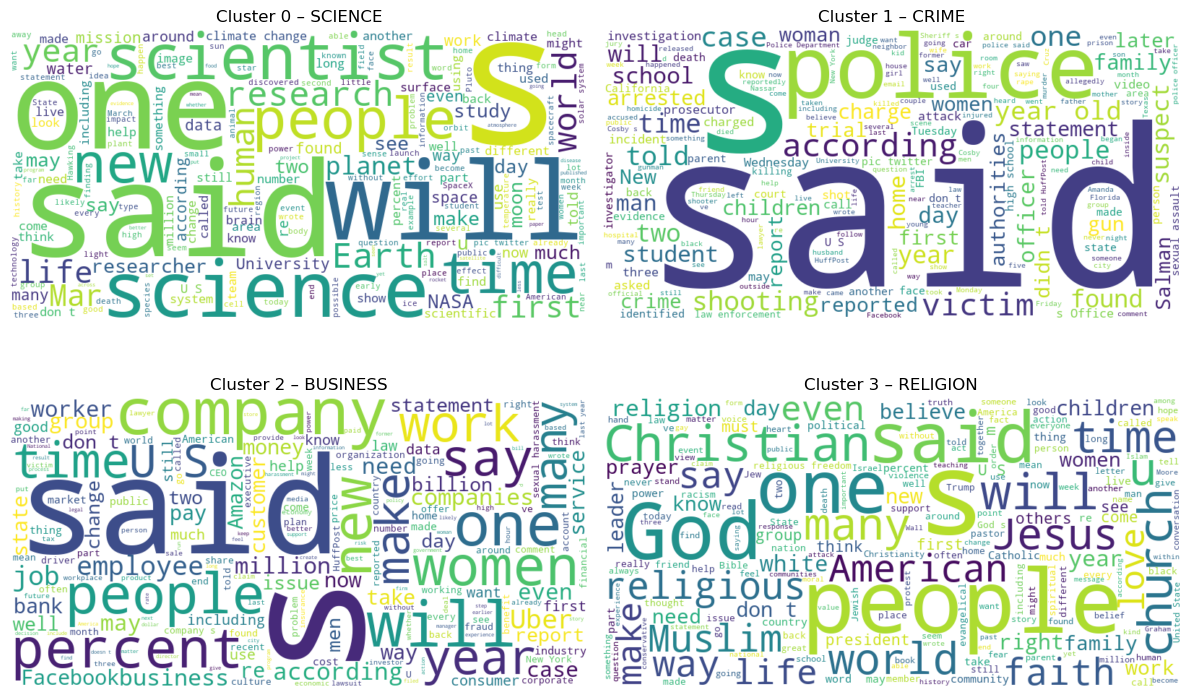

In [24]:
texts = X_task2["text"].reset_index(drop=True)
df_clusters = pd.DataFrame({'cluster': clusters, 'text': texts})
unique_clusters = sorted(df_clusters['cluster'].unique())
cols = 2
rows = math.ceil(len(unique_clusters) / cols)
plt.figure(figsize=(cols * 6, rows * 4))

for idx, cluster in enumerate(unique_clusters):
    cluster_text = " ".join(df_clusters[df_clusters['cluster'] == cluster]['text'])
    wc = WordCloud(width=800, height=400, background_color="white").generate(cluster_text)
    ax = plt.subplot(rows, cols, idx + 1)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Cluster {cluster} – {label_map.get(cluster, '')}")

plt.tight_layout()
plt.show()